In [2]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.3MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.83MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.6MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.18MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

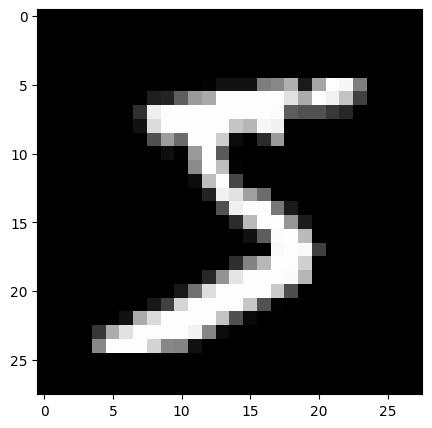

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter) # Use next(dataiter) instead of dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')



In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.fc1  = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64,2)
        self.relu = nn.ReLU()

        ## decoder ##
        self.dfc1 = nn.Linear(2 ,  64)
        self.dfc2 = nn.Linear(64,128)
        self.dfc3 = nn.Linear(128, 784)


    def forward(self, x):
        # define feedforward behavior
        # and scale the *output* layer with a sigmoid activation function
        # pass x into encoder
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        z = self.fc3(x)


        # pass out into decoder

        x = self.relu(self.dfc1(z))
        x = self.relu(self.dfc2(x))
        out = torch.sigmoid(self.dfc3(x))



        return out

# initialize the NN
encoding_dim = 64
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dfc1): Linear(in_features=2, out_features=64, bias=True)
  (dfc2): Linear(in_features=64, out_features=128, bias=True)
  (dfc3): Linear(in_features=128, out_features=784, bias=True)
)


In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# number of epochs to train the model
n_epochs = 10

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 1.025186
Epoch: 2 	Training Loss: 0.866510
Epoch: 3 	Training Loss: 0.831110
Epoch: 4 	Training Loss: 0.810497
Epoch: 5 	Training Loss: 0.795032
Epoch: 6 	Training Loss: 0.785847
Epoch: 7 	Training Loss: 0.778664
Epoch: 8 	Training Loss: 0.770615
Epoch: 9 	Training Loss: 0.764130
Epoch: 10 	Training Loss: 0.764079
Epoch: 11 	Training Loss: 0.757587
Epoch: 12 	Training Loss: 0.754744
Epoch: 13 	Training Loss: 0.753961
Epoch: 14 	Training Loss: 0.750571
Epoch: 15 	Training Loss: 0.744080
Epoch: 16 	Training Loss: 0.744175
Epoch: 17 	Training Loss: 0.745720
Epoch: 18 	Training Loss: 0.742779
Epoch: 19 	Training Loss: 0.736728
Epoch: 20 	Training Loss: 0.735588


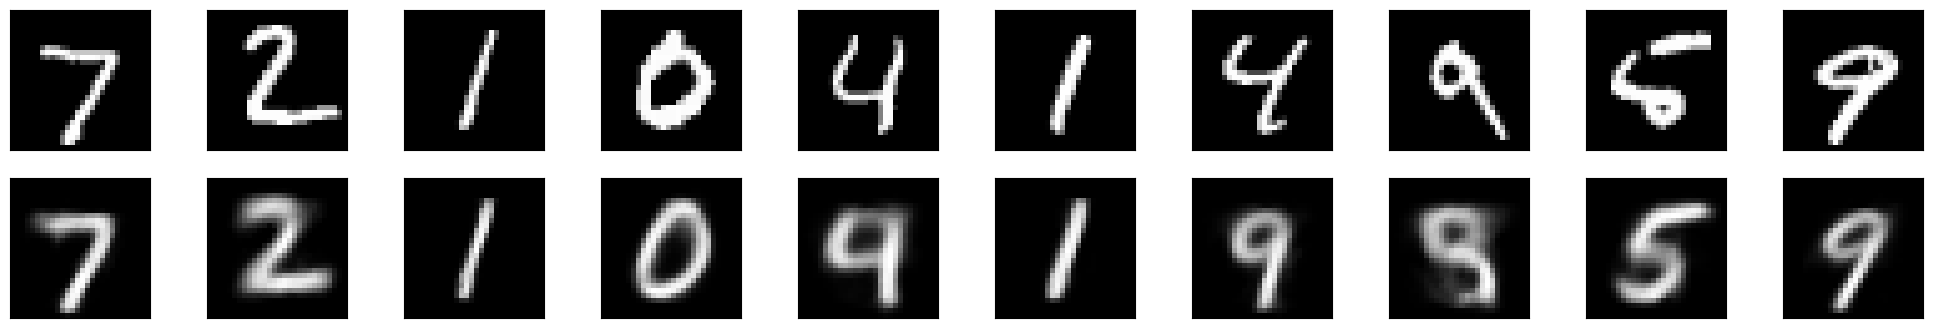

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


[link text](https://www.kaggle.com/code/sinclairg/pytorch-autoencoders-fashion-mnist)